In [1]:
from dotenv import load_dotenv
from googleapiclient.discovery import build
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_core.documents import Document
from langchain_community.tools import DuckDuckGoSearchRun
from typing import TypedDict
import os

In [2]:
# Load environment variables
load_dotenv()

# Initialize APIs
youtube = build('youtube', 'v3', developerKey=os.getenv("YOUTUBE_API_KEY"))
embedder = OpenAIEmbeddings(model="text-embedding-3-small")
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0.7)


In [3]:
class SearchResult:
    def __init__(self, search_result):
        self.video_id = search_result['id']['videoId']
        self.title = search_result['snippet']['title']
        self.transcript = self._get_transcript()

    def _get_transcript(self):
        try:
            transcript_list = YouTubeTranscriptApi.get_transcript(self.video_id)
            return " ".join([item['text'] for item in transcript_list])
        except Exception as e:
            print(f"Transcript error for {self.video_id}: {str(e)}")
            return ""

In [4]:
def search_yt(query, max_results=3):
    try:
        request = youtube.search().list(
            part="snippet",
            maxResults=max_results,
            q=query,
            videoCaption='closedCaption',
            type='video',
        )
        return request.execute().get('items', [])
    except Exception as e:
        print(f"YouTube API error: {str(e)}")
        return []

In [5]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200
)

In [6]:
def create_faiss_index(items):
    documents = []
    for item in items:
        result = SearchResult(item)
        if not result.transcript:
            continue
            
        full_text = f"Title: {result.title}\nTranscript: {result.transcript}"
        chunks = text_splitter.split_text(full_text)
        
        for chunk in chunks:
            documents.append(Document(
                page_content=chunk,
                metadata={
                    "video_id": result.video_id,
                    "title": result.title
                }
            ))
    
    if not documents:
        print("No valid documents created")
        return None
    
    try:
        return FAISS.from_documents(documents, embedder)
    except Exception as e:
        print(f"FAISS error: {str(e)}")
        return None

In [7]:
class State(TypedDict):
    topic: str
    author: str
    question: str
    objective_check: bool
    youtube_summary: str
    recent_fact_checks: str
    validation_feedback: str
    validate_fact_checks: str
    generate_summary: str
    check_author_style: str 

In [8]:
from typing import Optional
from langchain_core.runnables import RunnableLambda

In [9]:
def get_user_input(state=None) -> dict:
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "Is buying a dog an asset?",
        "youtube_summary": "",
        "objective_check": "",
        "validation_feedback": "",
        "recent_fact_checks": "",
        "validate_fact_checks": ""
    }


In [12]:
def YouTube_search(state: State):
    try:
        print("\n=== Starting YouTube Search ===")
        
        # Step 1: Search YouTube
        items = search_yt(f"{state['topic']} {state['author']}")
        if not items:
            print("❌ No search results found")
            return state
        print("✅ Valid search results found")
        
        # Step 2: Create FAISS index
        faiss_index = create_faiss_index(items)
        if not faiss_index:
            print("❌ FAISS index creation failed")
            return state
        print("✅ FAISS index created successfully")
        
        # Step 3: Setup RAG chain
        template = """Analyze and respond as {author} would. Rules:
        1. Use ONLY provided context
        2. Maintain {author}'s style
        3. State "Need information" if context is insufficient
        
        Context: {context}
        Question: {question}
        {author}'s analysis:"""
        
        prompt = ChatPromptTemplate.from_template(template)
        
        rag_chain = (
            {"context": faiss_index.as_retriever(), 
             "question": RunnablePassthrough(),
             "author": lambda _: state["author"]}
            | prompt 
            | llm
            | StrOutputParser()
        )
        
        # Step 4: Generate summary
        state["youtube_summary"] = rag_chain.invoke(state["question"])
        print("✅ YouTube summary generated successfully")
        return state
        
    except Exception as e:
        print(f"\n❌ Critical search error: {str(e)}")
        return state

In [13]:
def validate_user_input(state: State) -> State:
    try:
        validation_prompt = f"""Analyze if this user's question {state['question']} relates to {state['topic']}:
        Question: {state['question']}
        Author: {state['author']}
        Respond ONLY with 'True' or 'False'"""
        
        response = llm.invoke(validation_prompt).content.strip().lower()
        state["objective_check"] = response == "true"
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["objective_check"] = False
        return state

In [14]:
import re 

def validate_yt_summary(state: State) -> State:
    try:
        # Structured prompt with explicit formatting rules
        feedback_prompt = f"""ANALYSIS TASK:
        Verify if this YouTube summary adequately answers the user's question about {state['topic']} 
        in {state['author']}'s style. Use these strict criteria:

        [REQUIREMENTS]
        1. MUST directly address: "{state['question']}"
        2. MUST align with {state['author']}'s known perspectives
        3. MUST contain concrete information from the source

        [SUMMARY TO VALIDATE]
        {state['youtube_summary']}

        [RESPONSE FORMAT]
        - ONLY "VALID" if perfect
        - OR "SEARCH FOR CONTENT: [Topic Keywords] - {state['author']} - [Specific Aspect]"
        
        [EXAMPLE]
        SEARCH FOR CONTENT: wealth building strategies - Robert Kiyosaki - 2024 tax changes impact"""

        response = llm.invoke(feedback_prompt).content.strip()
        
        # Strict response parsing
        if "SEARCH FOR CONTENT:" in response.upper():
            # Extract first matching pattern and clean special characters
            search_query = response.split("SEARCH FOR CONTENT:")[-1].split("\n")[0].strip()
            search_query = re.sub(r'[^a-zA-Z0-9\s\-:]', '', search_query)  # Remove special chars
            state["validation_feedback"] = f"SEARCH FOR CONTENT: {search_query}"
        else:
            state["validation_feedback"] = "VALID" if "VALID" in response.upper() else "SEARCH FOR CONTENT: general update - {state['author']} - current trends"

        return state
    
    except Exception as e:
        print(f"🔴 Validation error: {str(e)}")
        state["validation_feedback"] = f"SEARCH FOR CONTENT: {state['topic']} - {state['author']} - latest updates"
        return state

In [15]:
def fact_checks(state: State) -> State:
    try:
        # Check if validation feedback contains search trigger
        if "SEARCH FOR CONTENT:" not in state['validation_feedback']:
            if state['validation_feedback'].upper() == "VALID":
                state["recent_fact_checks"] = "Fact check not needed"
                return state

        print("\n=== Starting Fact Check ===")
        
        # Extract clean search terms from validation feedback
        search_terms = state['validation_feedback'].split("SEARCH FOR CONTENT:")[-1].strip()
        
        # Build optimized search query
        search_query = f"{state['author']} {search_terms}"
        
        # Perform search with cleaned query
        search = DuckDuckGoSearchRun()
        results = search.invoke(search_query)
        
        # Handle empty results
        if not results or len(results) < 50:  # DDG often returns short error messages
            state["recent_fact_checks"] = "No credible articles found on this topic"
        else:
            state["recent_fact_checks"] = results[:1000]  # Limit response length
            
        print("✅ Fact check completed successfully")
        return state

    except Exception as e:
        print(f"Fact check error: {str(e)}")
        state["recent_fact_checks"] = "Error retrieving verification data"
        return state

In [16]:
def validate_facts(state: State) -> State:
    try:
        validation_prompt = f"""Analyze if this user's question {state['recent_fact_checks']} able to find the article :
        Respond ONLY with 'True' or 'False'"""
        
        response = llm.invoke(validation_prompt).content.strip().lower()
        state["validate_fact_checks"] = response == "true"
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["validate_fact_checks"] = False
        return state

In [ ]:
def consolidate_summary(state: State) -> State:
    try:
        # Structured prompt with explicit formatting rules

        if state["objective_check"] == False:
        print("The Question is not relevent to the Topic or i am not expertice in this topic")
        state["generate_summary"] = "The Question is not relevent to the Topic or i am not expertice in this topic"
        return state
        if state["validate_fact_checks"] = False
        state["generate_summary"] = "No credible articles found on this topic"
        return state
        if
        
    else:
        state["final_summary"] = "Valid"
        return state



        summary_prompt = f"""ANALYSIS TASK:
        Generate a summary of the user's question {state['question']} 
         i have provided below source for you to answer the question in {state['author']}'s style
        Generate summary with below source 
        1) {state['youtube_summary']}
        2) if {state['recent_fact_checks']} is available use this as well along with  {state['youtube_summary']} to answer the question

        [REQUIREMENTS]
        1. MUST directly address: "{state['question']}"
        2. MUST align with {state['author']}'s known perspectives and answer as like {state['author']}
        3. MUST contain concrete information from the source

        [SUMMARY TO GENERATE] 
        {state['youtube_summary']}
        {state['recent_fact_checks']} """
        state["generate_summary"] =  llm.invoke(summary_prompt).content.strip()
        print("✅ Summary generated successfully")
        return state
    except Exception as e:
        print(f"Summary generation error: {str(e)}")

In [119]:
if __name__ == "__main__":
    state = get_user_input()
    state = YouTube_search(state)
    
    if state.get("youtube_summary"):
        state = validate_user_input(state)
        state = validate_yt_summary(state)
        state = fact_checks(state)
        state = validate_facts(state)
        state = consolidate_summary(state)
        
        print("\nFinal Results:")
        print(f"Topic: {state['topic']}")
        print(f"Question: {state['question']}")
        print(f"Relevance Check: {state['objective_check']}")
        print(f"Summary Validation: {state['validation_feedback']}")
        print(f"Author Analysis:\n{state['youtube_summary']}")
        print(f"Recent Fact Checks: {state['recent_fact_checks']}")
        print(f"Fact Check Validation: {state['validate_fact_checks']}")
        print(f"Generated Summary: {state['generate_summary']}")
    else:
        print("Processing failed - check error logs")


=== Starting YouTube Search ===
✅ Valid search results found
✅ FAISS index created successfully
✅ YouTube summary generated successfully
✅ Summary generated successfully

Final Results:
Topic: Rich Dad Poor Dad
Question: Is buying a dog an asset?
Relevance Check: False
Summary Validation: VALID
Author Analysis:
Buying a dog is not an asset, it is a liability. Just like a bigger, flashier house, a dog will take money out of your pocket. It is important to understand the difference between an asset and a liability. Remember, high emotions can cloud financial intelligence, so it's crucial to make decisions based on cash flow and financial education.
Recent Fact Checks: Fact check not needed
Fact Check Validation: True
Generated Summary: Buying a dog is not an asset, it is a liability. Just like a bigger, flashier house, a dog will take money out of your pocket. It is important to understand the difference between an asset and a liability. Remember, high emotions can cloud financial intel

In [60]:

state["validation_feedback"]= "SEARCH FOR CONTENT: real estate market analysis - Robert Kiyosaki - 2024 housing market outlook"
#validate_yt_summary(state)
fact_checks(state)
print(f"Summary Validation: {state['validation_feedback']}")
print(f"Author Analysis:\n{state['youtube_summary']}")
print(f"Recent Fact Checks: {state['recent_fact_checks']}")


=== Starting Fact Check ===
✅ Fact check completed successfully
Summary Validation: SEARCH FOR CONTENT: real estate market analysis - Robert Kiyosaki - 2024 housing market outlook
Author Analysis:
The current economic condition presents a variety of opportunities for investments. However, it is crucial to understand that the best investment may not always be the most popular or conventional choice. Wise investors do not follow the crowd or invest in what is already popular. Instead, they look for opportunities that others may overlook and are willing to take calculated risks. Developing financial intelligence over a lifetime is key to recognizing and seizing these opportunities. Remember, the world is always handing you opportunities of a lifetime, it's up to you to see them and take advantage of them.
Recent Fact Checks: Is Robert Kiyosaki's "Rich Dad" approach to real estate investing outdated? We explore if his strategies can still help you build wealth in the 2024 market. ... and 

In [55]:
def get_user_input(state=None) -> dict:
    return {
        "topic": "Rich Dad Poor Dad",
        "author": "Robert Kiyosaki",
        "question": "current economic condition what is the best investment?",
        "youtube_summary": "",
        "objective_check": "",
        "validation_feedback": "",
        "recent_fact_checks": "",
    }

In [67]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["objective_check"] == True:
        print("Accepted")
        return "Accepted"
    elif state["objective_check"] == False:
        print("Rejected")
        return "Rejected"

In [122]:
def route_basedon_Summary(state: dict):
    """
    Route the input to the appropriate tool based on the input status
    """
    validation_feedback = state.get("validation_feedback", "")

    if validation_feedback == "Valid":
        print("Accepted")
        return "Accepted"
    else: "SEARCH" in validation_feedback
    print("need more info")
    return "need more info"
    # else:
    #     print("Error/Not relevent/Unknown Status")
    #     return "Rejected"


In [69]:
def end_summary(state: State):
    """
    Generate the final summary based on the input status
    """
    if state["objective_check"] == False:
        print("The Question is not relevent to the Topic or i am not expertice in this topic")
        state["final_summary"] = "The Question is not relevent to the Topic or i am not expertice in this topic"
        return state
    
    else:
        state["final_summary"] = "Valid"
        return state

In [70]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [ ]:
# Graph
Graphbuilder = StateGraph(State)
Graphbuilder.add_node("get_user_input", get_user_input)
Graphbuilder.add_node("YouTube_search",YouTube_search)
Graphbuilder.add_node("validate_user_input", validate_user_input)
Graphbuilder.add_node("validate_yt_summary", validate_yt_summary)
Graphbuilder.add_node("fact_checks", fact_checks)
Graphbuilder.add_node("consolidate_summary", consolidate_summary)
#Graphbuilder.add_node("validate_facts", validate_facts)
# Graphbuilder.add_node("check_author_style", check_author_style)
#Graphbuilder.add_node("end_summary", end_summary)


Graphbuilder.add_edge(START, "get_user_input")
Graphbuilder.add_edge("get_user_input", "YouTube_search")
Graphbuilder.add_edge("YouTube_search", "validate_user_input")
Graphbuilder.add_edge("YouTube_search", "validate_yt_summary")
Graphbuilder.add_edge("consolidate_summary", END)


Graphbuilder.add_conditional_edges(
    "validate_user_input",
    route_input,
    {
        "Accepted": "fact_checks",
        "Rejected": "end_summary"
    }
)


Graphbuilder.add_conditional_edges(
    "validate_yt_summary",
    route_basedon_Summary,
    {
        "Accepted": "consolidate_summary",
        "need more info": "fact_checks"
    }
)


Graphbuilder.add_conditional_edges(
    "fact_checks",
    validate_facts,
    {
        "Accepted": "consolidate_summary",
        "Rejected": "consolidate_summary"
    }
)



In [127]:
graph = Graphbuilder.compile()

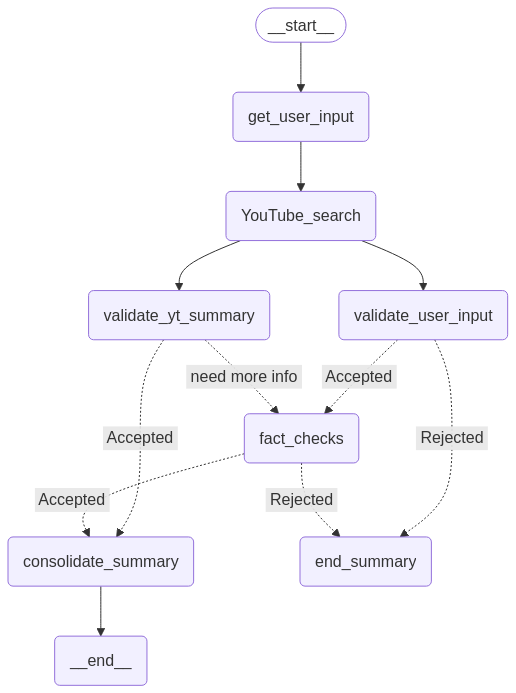

In [128]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [87]:
state = graph.invoke({
    "topic": "Rich Dad Poor Dad",
    "author": "Robert Kiyosaki",
    "question": "Is buying a house an asset?",
    "youtube_summary": "",
    "objective_check": "",
    "validation_feedback": "",
    "recent_fact_checks": "",
})

TypeError: get_user_input() takes 0 positional arguments but 1 was given

In [ ]:
class State(TypedDict):
    topic: str
    author: str
    question: str
    objective_check: bool
    youtube_summary: str
    recent_fact_checks: str
    validation_feedback: str
    generate_summary: str
    check_author_style: str
    final_summary: str 

In [ ]:
def youtube_summary_generate(state: State) -> State:
    """Generate a summary based on the YouTube video content"""
    summary_prompt = f"""
            Summarize the findings based on the following information:
            [Author] {state['author']}
            [Topic] {state['topic']}
            [Question] {state['question']}
            [Current Summary] {state['youtube_summary']}
            [Recent Fact Checks] {state['recent_fact_checks']}
            template = """Analyze and respond as {author} would. Rules:
            1. Use ONLY provided context
            2. Maintain {author}'s style'
            3. We have Provided all the required information to answer the question     
                Context: {context}
                Question: {question}
                {author}'s analysis: """
                
        prompt = ChatPromptTemplate.from_template(template)
        
        rag_chain = (
            {"context": faiss_index.as_retriever(), 
             "question": RunnablePassthrough(),
             "author": lambda _: state["author"]}
            | prompt 
            | llm
            | StrOutputParser()
        )
    state["youtube_summary"] = rag_chain.invoke(state["question"])
    return state

In [ ]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["input_status"] == True:
        print("Accepted")
        return "Accepted"
    elif state["input_status"] == False:
        print("Rejected")
        return "Rejected"

In [ ]:
def YouTube_search(state: State):
    try:
        print("\n=== Starting YouTube Search ===")
        
        # Step 1: Search YouTube
        items = search_yt(f"{state['topic']} {state['author']}")
        if not items:
            print("❌ No search results found")
            return state
        print("✅ Valid search results found")
        
        # Step 2: Create FAISS index
        faiss_index = create_faiss_index(items)
        if not faiss_index:
            print("❌ FAISS index creation failed")
            return state
        print("✅ FAISS index created successfully")
        
        # Step 3: Setup RAG chain
        youtube_summary_generate(state: State)
        print("✅ YouTube summary generated successfully")
        return state
        
    except Exception as e:
        print(f"\n❌ Critical search error: {str(e)}")
        return state

In [68]:
def get_author_style(author: str) -> str:
    """Returns style guidance without hardcoding specific authors"""
    return f"Maintain {author}'s signature communication style from their public works"

def get_style_keywords(author: str) -> str:
    """Generic style keywords adaptable to any author"""
    return "characteristic tone, terminology, and analytical approach"

In [ ]:
# def YouTube_search(state: State) -> State:
#     """Search YouTube and generate author-style analysis using FAISS+RAG"""
#     try:
#         print("\n=== Starting YouTube Search ===")
        
#         # Validate inputs
#         if not state.get("author") or not state.get("topic"):
#             raise ValueError("Missing author/topic in state")

#         # 1. YouTube Search with query validation
#         query = f"{state['topic']} {state['author']}".strip()[:500]
#         print(f"Searching for: {query}")
#         items = search_yt(query)
        
#         if not items:
#             print("❌ No search results found")
#             state["youtube_summary"] = "No relevant videos found"
#             return state
#         print(f"✅ Found {len(items)} videos")

#         # 2. FAISS Index Creation
#         faiss_index = create_faiss_index(items)
#         if not faiss_index or faiss_index.index.ntotal == 0:
#             print("❌ FAISS index creation failed - empty index")
#             state["youtube_summary"] = "Failed to process video content"
#             return state
#         print(f"✅ FAISS index created with {faiss_index.index.ntotal} chunks")

#         # 3. Corrected RAG Chain with proper input handling
#         template = """Synthesize response as {author} would:

#         Context from {author}'s works:
#         {context}

#         User Question: {question}

#         Requirements:
#         1. Use ONLY the provided context
#         2. Maintain {author}'s communication style
#         3. If information is missing, state what's needed

#         {author}'s analysis:"""
        
#         prompt = ChatPromptTemplate.from_template(template)
        
#         rag_chain = (
#             {
#                 "context": faiss_index.as_retriever(search_kwargs={"k": 3}),
#                 "question": itemgetter("question"),  # Proper input extraction
#                 "author": itemgetter("author")       # Direct field access
#             }
#             | prompt
#             | llm
#             | StrOutputParser()
#         )

#         # 4. Generate summary
#         state["youtube_summary"] = rag_chain.invoke({
#             "question": state["question"],
#             "author": state["author"]
#         })
        
#         print("✅ YouTube summary generated successfully")
#         return state

#     except Exception as e:
#         print(f"\n❌ Critical error in YouTube search: {str(e)}")
#         state["youtube_summary"] = f"Analysis failed: {str(e)}"
#         return state

In [105]:
def get_user_input() -> State:
    return {
        "topic": 'Rich Dad and Poor Dad',#'Artificial Intelligence',
        "author": "Robert Kiyosaki ",#'Yuval Noah Harari',
        "question": 'is buying a house  is an  asset ?',#'What are the implications of AI on society?',
        #"question": 'is suggest buying a house in current economic is a wise choise or what is my best investment option ?',#'What are the implications of AI on society?',
        #"question": 'Do you like Dogs',
        #"question": 'What are the implications of AI on society?',
        "youtube_summary": "",
        "objective_check": "",
        "validation_feedback": "",
        "recent_fact_checks": "",
    }

In [81]:
def validate_user_input(state: State) -> State:
    try:
        validation_prompt = f"""Analyze if this question relates to {state['topic']}:
        Question: {state['question']}
        Author: {state['author']}
        Respond ONLY with 'True' or 'False'"""
        
        response = llm.invoke(validation_prompt).content.strip().lower()
        state["objective_check"] = response == "true"
        return state
    except Exception as e:
        print(f"Validation error: {str(e)}")
        state["objective_check"] = False
        return state
    
def validate_yt_summary(state: State) -> State:
    try:
        # Structured prompt with clear formatting
        feedback_prompt = f"""Analyze this summary for missing information following these strict guidelines:

        [Author] {state['author']}
        [Topic] {state['topic']}
        [Question] {state['question']}
        [Current Summary] {state['youtube_summary']}

        --- ANALYSIS REQUIREMENTS ---
        1. Check if summary fully answers the question using {state['author']}'s known style/perspective
        2. Identify gaps in content or style alignment
        3. If missing information or contains "I need more information", generate 1 search phrase

        --- RESPONSE FORMAT ---
        VALID: If summary is sufficient
        SEARCH: [topic] - [author] - [specific_concept] (if needs improvement)

        --- EXAMPLE ---
        Author: Robert Kiyosaki
        Topic: Investment strategies
        Question: Is buying a house in current economy a good investment?
        Response: SEARCH: real estate market analysis - Robert Kiyosaki - 2024 housing market outlook"""

        response = llm.invoke(feedback_prompt).content.strip()
        
        # Robust parsing with fallback
        if "SEARCH:" in response.upper():
            search_query = response.split("SEARCH:")[-1].strip()
            state["validation_feedback"] = search_query
        else:
            state["validation_feedback"] = "VALID"
            
        return state
    
    except Exception as e:
        print(f"Summary validation error: {str(e)}")
        state["validation_feedback"] = f"ERROR: {str(e)}"
        return state


In [ ]:
def recent_fact_checks(state: State) -> State:
    try:
        # Build fact-checking prompt
        recent_fact_check_prompt = f"""
        Please check if there are any recent fact available or articles related to this topic use the following search terms:
        {state['validation_feedback']}
        Provide the latest fact-checking articles or summaries, if available. If not, respond with "No recent fact checks found available in this topic" """

        search = DuckDuckGoSearchRun()
        state["recent_fact_checks"] = search.invoke(state['validation_feedback'])
        print("✅ search is generated successfully")
        return state
    except Exception as e:
        print(f"Recent fact check error: {str(e)}")
        state["recent_fact_checks"] = "No atricle found in this topic"
        return state

    

In [ ]:
def recent_Summary_generate(state: State) -> State:
    try:
        # Build fact-checking prompt
        recent_fact_check_prompt = f"""
        Provided the facts " """

        search = DuckDuckGoSearchRun()
        state["recent_fact_checks"] = search.invoke(state['validation_feedback'])
        print("✅ search is generated successfully")
        return state
    except Exception as e:
        print(f"Recent fact check error: {str(e)}")
        state["recent_fact_checks"] = "No atricle found in this topic"
        return state

In [83]:
search = DuckDuckGoSearchRun()
search.invoke("state['question']")

"The 10 questions were proposed by citizens and the legislature as part of the state's direct democracy process. We're tracking the results. We're tracking the results. THE REIZ GIRLZ LLC is a California Limited-Liability Company - Ca filed on December 11, 2024. The company's filing status is listed as Active and its File Number is 202464910367. The Registered Agent on file for this company is Melia Thompson Dudiak and is located at 535 Main Street Suite 208, Martinez, CA 94553. Current term opinions can be found in the Opinions section of this site. For case information from previous terms, we recommend starting with the Docket Search located on the California Courts website (external); you can search by case number, case name, or names of the parties associated with the case. Joint Statement of Federal, State and Local California Leaders U.S. Representatives John Garamendi (D-CA-08) and Mark DeSaulnier (D-CA-10), California State Senator Tim Grayson, Martinez Mayor Brianne Zorn, and 

In [106]:
if __name__ == "__main__":
    state = get_user_input()
    state = YouTube_search(state)
    
    if state.get("youtube_summary"):
        state = validate_user_input(state)
        state = validate_yt_summary(state)
        state = recent_fact_checks(state)
        
        print("\nFinal Results:")
        print(f"Topic: {state['topic']}")
        print(f"Question: {state['question']}")
        print(f"Relevance Check: {state['objective_check']}")
        print(f"Summary Validation: {state['validation_feedback']}")
        print(f"Author Analysis:\n{state['youtube_summary']}")
        print(f"Recent Fact Checks: {state['recent_fact_checks']}")
    else:
        print("Processing failed - check error logs")


=== Starting YouTube Search ===
✅ Found 3 videos
✅ FAISS index created with 408 chunks
Summary generation error: argument 'text': 'dict' object cannot be converted to 'PyString'
✅ YouTube summary generated successfully
✅ search is generated successfully

Final Results:
Topic: Rich Dad and Poor Dad
Question: is buying a house  is an  asset ?
Relevance Check: True
Summary Validation: real estate investment - Robert Kiyosaki - definition of assets
Author Analysis:
Failed to generate summary
Recent Fact Checks: Robert Kiyosaki, the author of the bestselling book Rich Dad, Poor Dad, has profoundly influenced the way many people view wealth and investing. His teachings Investment Mindset: Kiyosaki promotes an investment mindset, urging readers to recognize income-generating opportunities in various areas, including stocks, real estate, and businesses. In today ... Good debt, on the other hand, is used to acquire assets that generate income or appreciate in value. This is crucial to understa

In [ ]:
print(state['validation_feedback'])

['real estate investment analysis - Robert Kiyosaki - asset classification']


In [15]:
class State(TypedDict):
    topic: str
    author: str
    question: str
    youtube_summary: str
    objective_check: bool
    validation_feedback: str
    recent_fact_checks: str
    generate_summary: str
    check_author_style: str
    final_summary: str 


In [ ]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode

In [ ]:
def generate_summary(state: State) -> State:
    """Generate a final summary based on the YouTube analysis and recent fact checks."""
    try:
        if state["validation_feedback"] == "VALID":
            
        tools = [youtube_summary_generate, recent_fact_checks])]
        # Step 4: Generate summary
        state["youtube_summary"] = llm_with_tools=llm.bind_tools(tools,parallel_tool_calls=True)

            Ensure the summary is concise and captures the essence of the analysis."""

In [58]:
search = DuckDuckGoSearchRun()
search.invoke("'real estate investment analysis - Robert Kiyosaki - asset classification'")

'Good debt, on the other hand, is used to acquire assets that generate income or appreciate in value. This is crucial to understanding how Robert Kiyosaki used debt, real estate, and gold to his advantage. Real Estate as a Foundation: Kiyosaki strongly advocates for using debt to invest in real estate. He sees property as a powerful wealth ... Robert Kiyosaki, the renowned author of "Rich Dad Poor Dad," has been a significant influence in the world of financial education, particularly in real estate investing. His strategies have helped many to navigate the complex landscape of property investment, building wealth through smart and calculated decisions. The rest of Robert Kiyosaki\'s stock portfolio. Beyond cryptocurrencies and precious metals, Kiyosaki diversifies his investments across various asset classes:. Real estate: Kiyosaki and his wife Kim have significant holdings in real estate, which forms the cornerstone of their investment strategy.They appreciate the dual benefits of re

In [17]:
os.environ["TAVILY_API_KEY"] = os.environ.get("TAVILY_API_KEY")

In [ ]:
from langchain_tavily import TavilySearch

In [ ]:
search = DuckDuckGoSearchRun()
search.invoke(" is suggest buying a house in current economic is a wise choise or what is my best investment any suggestion by  Robert Kiyosaki?")

In [20]:
from langgraph.prebuilt import create_react_agent

In [21]:
# Initialize Tavily Search Tool
tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

agent = create_react_agent(llm, [tavily_search_tool])

In [25]:
for step in agent.stream(
    {"messages": "is suggest buying a house in current economic is a wise choise or what is my best investment any suggestion by  Robert Kiyosaki?"},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

is suggest buying a house in current economic is a wise choise or what is my best investment any suggestion by  Robert Kiyosaki?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_4jk1fZinqtJB0zcBXA0LRXQu)
 Call ID: call_4jk1fZinqtJB0zcBXA0LRXQu
  Args:
    query: Robert Kiyosaki best investment advice
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "Robert Kiyosaki best investment advice", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.nasdaq.com/articles/robert-kiyosaki:-3-best-investing-tips-for-beginners", "title": "Robert Kiyosaki: 3 Best Investing Tips for Beginners - Nasdaq", "content": "Kiyosaki's favored way to invest is for cash flow. There are many ways to do this. One of the most obvious is to inv